In [1]:
# packages
import matplotlib.pyplot as plt
import numpy as np
import sys

import torch.optim
from torch import nn
from torchvision import transforms
import torch
import torchvision.transforms.functional as tf

# Dataset to train and test
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

from IPython.display import clear_output
from PIL import Image

In [85]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

torch.Size([1, 1, 28, 28])


IndexError: index 1 is out of bounds for dimension 0 with size 1

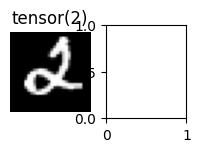

In [86]:
plt.figure(figsize=(6, 7))
for X, y in train_loader:
    print(X.shape)
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
        plt.title(y[i])
        plt.axis('off')
    break

In [88]:
def train(network, epochs, learning_rate, plot=True, verbose=True, loss=None):
    loss = loss or nn.NLLLoss()
    optimizer = torch.optim.Adam(params=network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            network.train()
            losses = []
            accuracies = []
            for X, y in train_loader:
                network.zero_grad()
                X = X.view(-1, 784)
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                loss_batch.backward()
                optimizer.step()
                accuracies.append((np.argmax(prediction.data.numpy(), 1) == y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []
            network.eval()
            with torch.no_grad():
                for X, y in test_loader:
                    X = X.view(-1, 784)
                    prediction = network(X)
                    loss_batch = loss(prediction, y)
                    losses.append(loss_batch.item())
                    accuracies.append((np.argmax(prediction.data.numpy(), 1) == y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                    epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                    train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
        test_loss_epochs, \
        train_accuracy_epochs, \
        test_accuracy_epochs

In [89]:
class ConvClassifier(nn.Module):
    def __init__(self):
        super(ConvClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 8, (3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, (3, 3), padding=1),
            nn.ReLU()
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(3136, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [90]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.Softmax(),
        )

    def forward(self, x):
        logits = self.layers(x)
        return logits

In [91]:
network = NeuralNetwork()
conv_classifier = ConvClassifier()

Epoch 1... (Train/Test) NLL: 2.362/2.363	Accuracy: 0.099/0.098

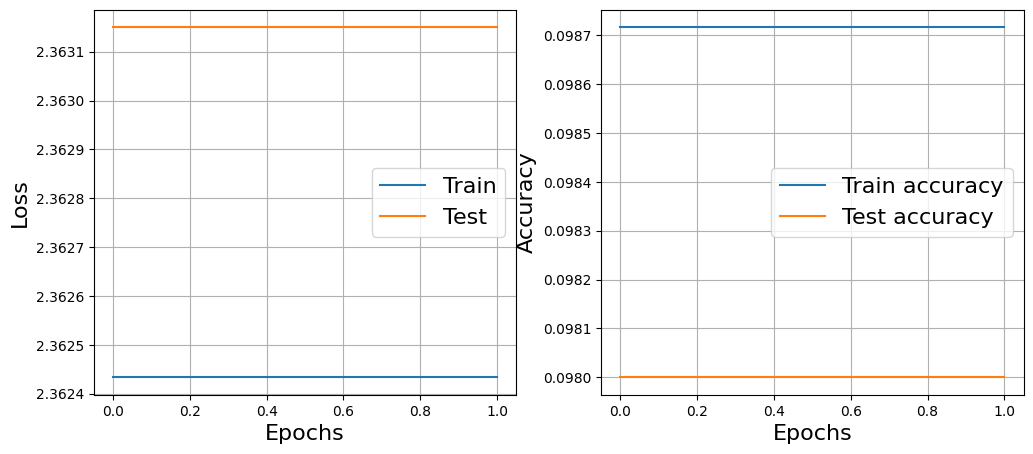

([2.3624334909379483, 2.3624334909379483],
 [2.363150157690048, 2.363150157690048],
 [0.09871666666666666, 0.09871666666666666],
 [0.098, 0.098])

In [93]:
train(network, 20, 0.01, True, True, nn.CrossEntropyLoss())

Epoch 19... (Train/Test) NLL: 0.063/0.221	Accuracy: 0.991/0.976

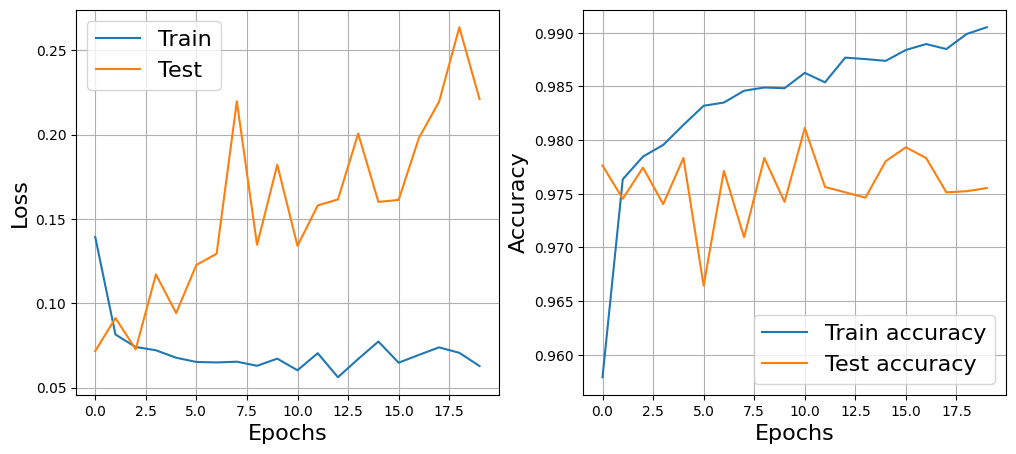

In [36]:
tr_s, ts_s, tr_ac, ts_ac = train(conv_classifier, 20, 0.01, True, True, nn.NLLLoss())

In [37]:
conv_classifier.eval()

ConvClassifier(
  (conv_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=3136, out_features=10, bias=True)
    (1): LogSoftmax(dim=1)
  )
)

In [30]:
pictures = []
nums = []
for X, y in test_loader:
    output = conv_classifier()
    output = output.argmax(axis=1)
    for i in range(X.shape[0]):
        if output[i] != y[i]:
            pictures.append(X[i])
            nums.append(f"({(output[i])})/{y[i]}")

NameError: name 'output' is not defined

### Load test data

In [79]:
img = Image.open('test_dataset/3.png').convert('L')

img = np.asarray(img)

img = tf.to_tensor(img)
# plt.imshow(img.reshape(28, 28), cmap=plt.cm.Greys_r)

img = img.expand(1, 1, 28, 28)
img.shape

torch.Size([1, 1, 28, 28])

In [80]:
pictures = []
nums = []

output = conv_classifier(img)
print(output)
output = output.argmax(axis=1)

tensor([[-3.2331, -0.2624, -3.0208, -3.5947, -3.8047, -4.1479, -3.8584, -3.7191,
         -4.1116, -4.1794]], grad_fn=<LogSoftmaxBackward0>)


(-0.5, 27.5, 27.5, -0.5)

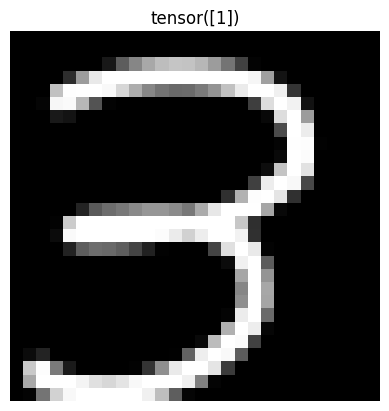

In [81]:
plt.imshow(img.reshape(28, 28), cmap=plt.cm.Greys_r)
plt.title(output)
plt.axis('off')

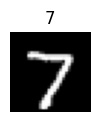

In [74]:
plt.figure(figsize=(6, 7))
for X, y in test_dataset:
    plt.subplot(5, 5, i + 1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y)
    plt.axis('off')
    break